In [1]:
import pandas as pd
from MatrixVectorizer import *
import torch
import random
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import seaborn as sns

In [2]:
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Check for CUDA (GPU support) and set device accordingly
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # For multi-GPU setups
    # Additional settings for ensuring reproducibility on CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device("cpu")
    print("CUDA not available. Using CPU.")

CUDA not available. Using CPU.


In [3]:
LR_size = 160
HR_size = 268

# Load Data

In [4]:
def antivectorize_df(adj_mtx_df, size):
    
    num_subject = adj_mtx_df.shape[0]
    adj_mtx = np.zeros((num_subject, size, size)) #torch.zeros((num_subject, LR_size, LR_size))
    for i in range(num_subject):
        adj_mtx[i] = MatrixVectorizer.anti_vectorize(adj_mtx_df.iloc[i], size) # torch.from_numpy(MatrixVectorizer.anti_vectorize(A_LR_train.iloc[i], LR_size))
    return adj_mtx


# A_LR_train = pd.read_csv("../data/lr_train.csv")
# A_HR_train = pd.read_csv("../data/hr_train.csv")
# A_LR_test = pd.read_csv("../data/lr_test.csv")

# np.save('A_LR_train_matrix.npy', antivectorize_df(A_LR_train, LR_size))
# np.save('A_HR_train_matrix.npy', antivectorize_df(A_HR_train, HR_size))
# np.save('A_LR_test_matrix.npy', antivectorize_df(A_LR_test, LR_size))

In [5]:
A_LR_train_matrix = np.load('A_LR_train_matrix.npy')
A_HR_train_matrix = np.load('A_HR_train_matrix.npy')
A_LR_test_matrix = np.load("A_LR_test_matrix.npy")

print(A_LR_train_matrix.shape)
print(A_HR_train_matrix.shape)
print(A_LR_test_matrix.shape)

(167, 160, 160)
(167, 268, 268)
(112, 160, 160)


# Parameters

In [6]:
import numpy as np
import torch.optim as optim
from sklearn.model_selection import KFold
from preprocessing import *
from model import *
from train import *
import argparse



epochs = 200
lmbda = 16 # 16
hidden_dim = 560


parser = argparse.ArgumentParser(description='GSR-Net')
parser.add_argument('--epochs', type=int, default=epochs, metavar='no_epochs',
                help='number of episode to train ')
parser.add_argument('--lr', type=float, default=0.0001, metavar='lr',
                help='learning rate (default: 0.0001 using Adam Optimizer)')
parser.add_argument('--splits', type=int, default=3, metavar='n_splits',
                help='no of cross validation folds')
parser.add_argument('--lmbda', type=int, default=lmbda, metavar='L',
                help='self-reconstruction error hyperparameter')
parser.add_argument('--lr_dim', type=int, default=LR_size, metavar='N',
                help='adjacency matrix input dimensions')
parser.add_argument('--hr_dim', type=int, default=HR_size, metavar='N',
                help='super-resolved adjacency matrix output dimensions')
parser.add_argument('--hidden_dim', type=int, default=hidden_dim, metavar='N',
                help='hidden GraphConvolutional layer dimensions')
parser.add_argument('--padding', type=int, default=26, metavar='padding',
                help='dimensions of padding')
# parser.add_argument('--padding', type=int, default=26, metavar='padding',
#                 help='dimensions of padding')
parser.add_argument('--embedding_size', type=int, default=32, metavar='embedding_size',
                help='node embedding size')
parser.add_argument('--early_stop_patient', type=int, default=5, metavar='early_stop_patient',
                help='early_stop_patience')

parser.add_argument('--mean_dense', type=float, default=0., metavar='mean',
                        help='mean of the normal distribution in Dense Layer')
parser.add_argument('--std_dense', type=float, default=0.01, metavar='std',
                    help='standard deviation of the normal distribution in Dense Layer')
parser.add_argument('--mean_gaussian', type=float, default=0., metavar='mean',
                    help='mean of the normal distribution in Gaussian Noise Layer')
parser.add_argument('--std_gaussian', type=float, default=0.1, metavar='std',
                    help='standard deviation of the normal distribution in Gaussian Noise Layer')



# Create an empty Namespace to hold the default arguments
args = parser.parse_args([]) 
print(args)

Namespace(epochs=200, lr=0.0001, splits=3, lmbda=16, lr_dim=160, hr_dim=268, hidden_dim=560, padding=26, embedding_size=32, early_stop_patient=5, mean_dense=0.0, std_dense=0.01, mean_gaussian=0.0, std_gaussian=0.1)


In [7]:
# SIMULATING THE DATA: EDIT TO ENTER YOUR OWN DATA
X = A_LR_train_matrix #np.random.normal(0, 0.5, (167, 160, 160))
Y = A_HR_train_matrix #np.random.normal(0, 0.5, (167, 288, 288))
print(X.shape)
print(Y.shape)

(167, 160, 160)
(167, 268, 268)


In [8]:
device = get_device()
print(device)

cpu


# Normalization

In [9]:
def compute_degree_matrix_normalization_batch_numpy(adjacency_batch):
    """
    Optimizes the degree matrix normalization for a batch of adjacency matrices using NumPy.
    Computes the normalized adjacency matrix D^-1 * A for each graph in the batch.
    
    Parameters:
    - adjacency_batch: A NumPy array of shape (batch_size, num_nodes, num_nodes) representing
                       a batch of adjacency matrices.

    Returns:
    - A NumPy array of normalized adjacency matrices.
    """
    epsilon = 1e-6  # Small constant to avoid division by zero
    # Calculate the degree for each node in the batch
    d = adjacency_batch.sum(axis=2) + epsilon
    
    # Compute the inverse degree matrix D^-1 for the batch
    D_inv = np.reciprocal(d)[:, :, np.newaxis] * np.eye(adjacency_batch.shape[1])[np.newaxis, :, :]
    
    # Normalize the adjacency matrix using batch matrix multiplication
    normalized_adjacency_batch = np.matmul(D_inv, adjacency_batch)
    
    return normalized_adjacency_batch

def symmetric_norm(A):
    num_samples = A.shape[0]  # Number of samples, i.e., slices in the 3D tensor

    # Initialize an empty array for the normalized matrices
    A_normalized = np.zeros_like(A)

    for i in range(num_samples):
        # Extract the i-th adjacency matrix
        Ai = A[i, :, :]
        
        # Compute the degree matrix D and its inverse square root for Ai
        Di = np.diag(np.sum(Ai, axis=1))
        D_inv_sqrt_i = np.linalg.inv(np.sqrt(Di))
        
        # Normalize the adjacency matrix
        A_normalized[i, :, :] = D_inv_sqrt_i @ Ai @ D_inv_sqrt_i
    return A_normalized

def compute_pagerank_normalization(adjacency_matrices):
    """
    Normalizes each adjacency matrix in a batch using PageRank centrality values.
    
    Parameters:
    - adjacency_matrices: A NumPy array with shape (n_samples, n_dim, n_dim) representing the adjacency matrices.
    
    Returns:
    - A NumPy array of the same shape, with each adjacency matrix normalized.
    """
    n_samples, n_dim, _ = adjacency_matrices.shape
    normalized_matrices = np.zeros_like(adjacency_matrices)
    
    for i in tqdm(range(n_samples)):
        adjacency = adjacency_matrices[i]
        
        # Convert adjacency matrix to graph
        G = nx.from_numpy_array(adjacency, create_using=nx.DiGraph)
        
        # Compute PageRank
        pr_dict = nx.pagerank(G, alpha=0.85, max_iter=100, tol=1e-6)
        
        # Create a diagonal matrix with PageRank values
        pr_values = np.array([pr_dict[node] for node in range(n_dim)])
        pr_diag = np.diag(pr_values)
        
        # Normalize the adjacency matrix using the PageRank diagonal matrix
        normalized_adjacency = np.dot(pr_diag, adjacency)
        
        normalized_matrices[i] = normalized_adjacency
    
    return normalized_matrices
    

# X = compute_pagerank_normalization(X)
# A_LR_test_matrix = compute_pagerank_normalization(A_LR_test_matrix)

X = compute_degree_matrix_normalization_batch_numpy(X)
A_LR_test_matrix = compute_degree_matrix_normalization_batch_numpy(A_LR_test_matrix)

# X = symmetric_norm(X)
# A_LR_test_matrix = symmetric_norm(A_LR_test_matrix)

# print(X.shape)

# K-Fold cross validation

In [10]:
cv = KFold(n_splits=args.splits, random_state=random_seed, shuffle=True)

ks = [0.9, 0.7, 0.6, 0.5]

best_model_fold_list = []
data_fold_list = []
i = 1
for train_index, test_index in cv.split(X):

    print(f"----- Fold {i} -----")

    subjects_adj, test_adj, subjects_ground_truth, test_ground_truth = X[
        train_index], X[test_index], Y[train_index], Y[test_index]
    data_fold_list.append((subjects_adj, test_adj, subjects_ground_truth, test_ground_truth))


    netG = GSRNet(ks, args).to(device)
    optimizerG = optim.Adam(netG.parameters(), lr=args.lr)

    netD = Discriminator(args).to(device)
    optimizerD = optim.Adam(netD.parameters(), lr=args.lr)

    # return_model = train_gan(
    #     netG, 
    #     optimizerG, 
    #     netD,
    #     optimizerD,
    #     subjects_adj, 
    #     subjects_ground_truth, 
    #     args, 
    #     test_adj=test_adj, 
    #     test_ground_truth=test_ground_truth
    # )

    return_model = train(netG, optimizerG, subjects_adj, subjects_ground_truth, args, test_adj, test_ground_truth)
    test_mae = test(return_model, test_adj, test_ground_truth, args)
    print(f"Val MAE: {test_mae}")
    best_model_fold_list.append(return_model)

    i += 1

----- Fold 1 -----
0.5 0.03 0.1


Epoch Progress:   0%|          | 1/200 [00:27<1:29:57, 27.12s/epoch]

Epoch: 1, Train Loss: 0.389352, Train Error: 0.230743, Test Error: 0.189755


Epoch Progress:   1%|          | 2/200 [00:53<1:28:06, 26.70s/epoch]

Epoch: 2, Train Loss: 0.314724, Train Error: 0.187838, Test Error: 0.179117


Epoch Progress:   2%|▏         | 3/200 [01:20<1:28:09, 26.85s/epoch]

Epoch: 3, Train Loss: 0.294109, Train Error: 0.183174, Test Error: 0.177059


Epoch Progress:   2%|▏         | 4/200 [01:46<1:27:05, 26.66s/epoch]

Epoch: 4, Train Loss: 0.289471, Train Error: 0.180862, Test Error: 0.175637


Epoch Progress:   2%|▎         | 5/200 [02:13<1:26:56, 26.75s/epoch]

Epoch: 5, Train Loss: 0.275756, Train Error: 0.179584, Test Error: 0.173928


Epoch Progress:   3%|▎         | 6/200 [02:40<1:26:06, 26.63s/epoch]

Epoch: 6, Train Loss: 0.270152, Train Error: 0.178079, Test Error: 0.172565


Epoch Progress:   4%|▎         | 7/200 [03:07<1:25:55, 26.71s/epoch]

Epoch: 7, Train Loss: 0.263651, Train Error: 0.177711, Test Error: 0.171202


Epoch Progress:   4%|▍         | 8/200 [03:34<1:25:56, 26.86s/epoch]

Epoch: 8, Train Loss: 0.263359, Train Error: 0.176719, Test Error: 0.170880


Epoch Progress:   4%|▍         | 9/200 [04:01<1:25:25, 26.83s/epoch]

Epoch: 9, Train Loss: 0.254625, Train Error: 0.175784, Test Error: 0.170006


Epoch Progress:   5%|▌         | 10/200 [04:27<1:24:27, 26.67s/epoch]

Epoch: 10, Train Loss: 0.252669, Train Error: 0.174812, Test Error: 0.169332


Epoch Progress:   6%|▌         | 11/200 [04:53<1:23:50, 26.62s/epoch]

Epoch: 11, Train Loss: 0.247688, Train Error: 0.174579, Test Error: 0.168298


Epoch Progress:   6%|▌         | 12/200 [05:20<1:23:43, 26.72s/epoch]

Epoch: 12, Train Loss: 0.243711, Train Error: 0.173715, Test Error: 0.166938


Epoch Progress:   6%|▋         | 13/200 [05:47<1:22:45, 26.56s/epoch]

Epoch: 13, Train Loss: 0.242706, Train Error: 0.172716, Test Error: 0.166149


Epoch Progress:   7%|▋         | 14/200 [06:13<1:22:26, 26.59s/epoch]

Epoch: 14, Train Loss: 0.238529, Train Error: 0.171707, Test Error: 0.165215


Epoch Progress:   8%|▊         | 15/200 [06:40<1:21:55, 26.57s/epoch]

Epoch: 15, Train Loss: 0.240365, Train Error: 0.171401, Test Error: 0.163815


Epoch Progress:   8%|▊         | 16/200 [07:06<1:21:20, 26.53s/epoch]

Epoch: 16, Train Loss: 0.234963, Train Error: 0.170116, Test Error: 0.162962


Epoch Progress:   8%|▊         | 17/200 [07:33<1:20:48, 26.49s/epoch]

Epoch: 17, Train Loss: 0.230763, Train Error: 0.168251, Test Error: 0.162672


Epoch Progress:   9%|▉         | 18/200 [07:59<1:20:03, 26.39s/epoch]

Epoch: 18, Train Loss: 0.229198, Train Error: 0.168192, Test Error: 0.160562


Epoch Progress:  10%|▉         | 19/200 [08:26<1:20:01, 26.53s/epoch]

Epoch: 19, Train Loss: 0.229291, Train Error: 0.167233, Test Error: 0.158887


Epoch Progress:  10%|█         | 20/200 [08:53<1:20:39, 26.89s/epoch]

Epoch: 20, Train Loss: 0.226748, Train Error: 0.166367, Test Error: 0.157827


Epoch Progress:  10%|█         | 21/200 [09:20<1:19:59, 26.81s/epoch]

Epoch: 21, Train Loss: 0.224370, Train Error: 0.164824, Test Error: 0.156223


Epoch Progress:  11%|█         | 22/200 [09:47<1:19:21, 26.75s/epoch]

Epoch: 22, Train Loss: 0.220501, Train Error: 0.162476, Test Error: 0.155135


Epoch Progress:  12%|█▏        | 23/200 [10:13<1:18:35, 26.64s/epoch]

Epoch: 23, Train Loss: 0.216783, Train Error: 0.161490, Test Error: 0.153942


Epoch Progress:  12%|█▏        | 24/200 [10:39<1:17:47, 26.52s/epoch]

Epoch: 24, Train Loss: 0.221243, Train Error: 0.162231, Test Error: 0.152726


Epoch Progress:  12%|█▎        | 25/200 [11:06<1:17:15, 26.49s/epoch]

Epoch: 25, Train Loss: 0.214286, Train Error: 0.158938, Test Error: 0.151914


Epoch Progress:  13%|█▎        | 26/200 [11:32<1:17:00, 26.55s/epoch]

Epoch: 26, Train Loss: 0.213856, Train Error: 0.158640, Test Error: 0.150254


Epoch Progress:  14%|█▎        | 27/200 [11:59<1:16:26, 26.51s/epoch]

Epoch: 27, Train Loss: 0.209872, Train Error: 0.156775, Test Error: 0.150053


Epoch Progress:  14%|█▍        | 28/200 [12:25<1:16:08, 26.56s/epoch]

Epoch: 28, Train Loss: 0.208868, Train Error: 0.155905, Test Error: 0.150089


Epoch Progress:  14%|█▍        | 29/200 [12:52<1:15:58, 26.66s/epoch]

Epoch: 29, Train Loss: 0.209090, Train Error: 0.154912, Test Error: 0.148115


Epoch Progress:  15%|█▌        | 30/200 [13:19<1:15:56, 26.80s/epoch]

Epoch: 30, Train Loss: 0.207139, Train Error: 0.153341, Test Error: 0.147684


Epoch Progress:  16%|█▌        | 31/200 [13:46<1:15:11, 26.69s/epoch]

Epoch: 31, Train Loss: 0.205045, Train Error: 0.151253, Test Error: 0.147288


Epoch Progress:  16%|█▌        | 32/200 [14:13<1:14:54, 26.75s/epoch]

Epoch: 32, Train Loss: 0.199250, Train Error: 0.149453, Test Error: 0.146024


Epoch Progress:  16%|█▋        | 33/200 [14:39<1:14:06, 26.62s/epoch]

Epoch: 33, Train Loss: 0.201184, Train Error: 0.148958, Test Error: 0.145409


Epoch Progress:  17%|█▋        | 34/200 [15:07<1:14:23, 26.89s/epoch]

Epoch: 34, Train Loss: 0.198571, Train Error: 0.147597, Test Error: 0.144358


Epoch Progress:  18%|█▊        | 35/200 [15:33<1:13:51, 26.86s/epoch]

Epoch: 35, Train Loss: 0.196864, Train Error: 0.146623, Test Error: 0.143467


Epoch Progress:  18%|█▊        | 36/200 [16:00<1:13:11, 26.78s/epoch]

Epoch: 36, Train Loss: 0.196174, Train Error: 0.145498, Test Error: 0.143319


Epoch Progress:  18%|█▊        | 37/200 [16:26<1:12:30, 26.69s/epoch]

Epoch: 37, Train Loss: 0.193014, Train Error: 0.144309, Test Error: 0.142255


Epoch Progress:  19%|█▉        | 38/200 [16:53<1:12:05, 26.70s/epoch]

Epoch: 38, Train Loss: 0.194955, Train Error: 0.144414, Test Error: 0.141281


Epoch Progress:  20%|█▉        | 39/200 [17:20<1:11:36, 26.69s/epoch]

Epoch: 39, Train Loss: 0.191570, Train Error: 0.142498, Test Error: 0.140605


Epoch Progress:  20%|██        | 40/200 [17:49<1:13:11, 27.45s/epoch]

Epoch: 40, Train Loss: 0.192088, Train Error: 0.142297, Test Error: 0.140659


Epoch Progress:  20%|██        | 41/200 [18:16<1:12:36, 27.40s/epoch]

Epoch: 41, Train Loss: 0.189535, Train Error: 0.141820, Test Error: 0.140703


Epoch Progress:  21%|██        | 42/200 [18:43<1:11:17, 27.07s/epoch]

Epoch: 42, Train Loss: 0.188287, Train Error: 0.141081, Test Error: 0.140498


Epoch Progress:  22%|██▏       | 43/200 [19:09<1:10:37, 26.99s/epoch]

Epoch: 43, Train Loss: 0.187873, Train Error: 0.140366, Test Error: 0.139167


Epoch Progress:  22%|██▏       | 44/200 [19:35<1:09:28, 26.72s/epoch]

Epoch: 44, Train Loss: 0.185802, Train Error: 0.139754, Test Error: 0.139965


Epoch Progress:  22%|██▎       | 45/200 [20:02<1:08:45, 26.61s/epoch]

Epoch: 45, Train Loss: 0.187114, Train Error: 0.139384, Test Error: 0.138849


Epoch Progress:  23%|██▎       | 46/200 [20:29<1:08:32, 26.71s/epoch]

Epoch: 46, Train Loss: 0.184638, Train Error: 0.138668, Test Error: 0.139799


Epoch Progress:  24%|██▎       | 47/200 [20:55<1:07:57, 26.65s/epoch]

Epoch: 47, Train Loss: 0.184432, Train Error: 0.138306, Test Error: 0.139088


Epoch Progress:  24%|██▍       | 48/200 [21:23<1:08:02, 26.86s/epoch]

Epoch: 48, Train Loss: 0.184933, Train Error: 0.138825, Test Error: 0.138155


Epoch Progress:  24%|██▍       | 49/200 [21:49<1:07:16, 26.73s/epoch]

Epoch: 49, Train Loss: 0.183413, Train Error: 0.137747, Test Error: 0.138325


Epoch Progress:  25%|██▌       | 50/200 [22:16<1:06:53, 26.76s/epoch]

Epoch: 50, Train Loss: 0.184319, Train Error: 0.138160, Test Error: 0.138199


Epoch Progress:  26%|██▌       | 51/200 [22:42<1:05:59, 26.57s/epoch]

Epoch: 51, Train Loss: 0.184805, Train Error: 0.137570, Test Error: 0.137351


Epoch Progress:  26%|██▌       | 52/200 [23:09<1:06:07, 26.81s/epoch]

Epoch: 52, Train Loss: 0.180886, Train Error: 0.136554, Test Error: 0.137428


Epoch Progress:  26%|██▋       | 53/200 [23:36<1:05:46, 26.85s/epoch]

Epoch: 53, Train Loss: 0.181080, Train Error: 0.136777, Test Error: 0.136909


Epoch Progress:  27%|██▋       | 54/200 [24:03<1:05:20, 26.85s/epoch]

Epoch: 54, Train Loss: 0.180659, Train Error: 0.136585, Test Error: 0.136875


Epoch Progress:  28%|██▊       | 55/200 [24:29<1:04:24, 26.65s/epoch]

Epoch: 55, Train Loss: 0.181123, Train Error: 0.136555, Test Error: 0.136978


Epoch Progress:  28%|██▊       | 56/200 [24:56<1:04:04, 26.70s/epoch]

Epoch: 56, Train Loss: 0.179777, Train Error: 0.135524, Test Error: 0.137165


Epoch Progress:  28%|██▊       | 57/200 [25:23<1:03:53, 26.81s/epoch]

Epoch: 57, Train Loss: 0.182600, Train Error: 0.136826, Test Error: 0.136338


Epoch Progress:  29%|██▉       | 58/200 [25:49<1:02:58, 26.61s/epoch]

Epoch: 58, Train Loss: 0.179960, Train Error: 0.135568, Test Error: 0.136730


Epoch Progress:  30%|██▉       | 59/200 [26:16<1:02:40, 26.67s/epoch]

Epoch: 59, Train Loss: 0.181056, Train Error: 0.136149, Test Error: 0.137551


Epoch Progress:  30%|███       | 60/200 [26:43<1:02:01, 26.59s/epoch]

Epoch: 60, Train Loss: 0.179736, Train Error: 0.135793, Test Error: 0.136795


Epoch Progress:  30%|███       | 61/200 [27:09<1:01:35, 26.59s/epoch]

Epoch: 61, Train Loss: 0.180085, Train Error: 0.135306, Test Error: 0.136289


Epoch Progress:  31%|███       | 62/200 [27:36<1:00:59, 26.51s/epoch]

Epoch: 62, Train Loss: 0.177879, Train Error: 0.134699, Test Error: 0.136339


Epoch Progress:  32%|███▏      | 63/200 [28:02<1:00:16, 26.40s/epoch]

Epoch: 63, Train Loss: 0.179034, Train Error: 0.135706, Test Error: 0.135667


Epoch Progress:  32%|███▏      | 64/200 [28:28<59:51, 26.41s/epoch]  

Epoch: 64, Train Loss: 0.178072, Train Error: 0.134992, Test Error: 0.136031


Epoch Progress:  32%|███▎      | 65/200 [28:54<59:09, 26.30s/epoch]

Epoch: 65, Train Loss: 0.178068, Train Error: 0.134527, Test Error: 0.135790


Epoch Progress:  33%|███▎      | 66/200 [29:21<58:55, 26.39s/epoch]

Epoch: 66, Train Loss: 0.178488, Train Error: 0.134952, Test Error: 0.136461


Epoch Progress:  34%|███▎      | 67/200 [29:47<58:13, 26.27s/epoch]

Epoch: 67, Train Loss: 0.178113, Train Error: 0.134465, Test Error: 0.135896


Epoch Progress:  34%|███▍      | 68/200 [30:13<57:53, 26.32s/epoch]

Epoch: 68, Train Loss: 0.177127, Train Error: 0.134505, Test Error: 0.135784


Epoch Progress:  34%|███▍      | 69/200 [30:39<57:10, 26.19s/epoch]

Epoch: 69, Train Loss: 0.177623, Train Error: 0.134396, Test Error: 0.135444


Epoch Progress:  35%|███▌      | 70/200 [31:05<56:48, 26.22s/epoch]

Epoch: 70, Train Loss: 0.176086, Train Error: 0.134329, Test Error: 0.135478


Epoch Progress:  36%|███▌      | 71/200 [35:53<3:45:14, 104.76s/epoch]

Epoch: 71, Train Loss: 0.175857, Train Error: 0.134045, Test Error: 0.134601


Epoch Progress:  36%|███▌      | 72/200 [36:19<2:52:50, 81.02s/epoch] 

Epoch: 72, Train Loss: 0.176816, Train Error: 0.134155, Test Error: 0.134800


Epoch Progress:  36%|███▋      | 73/200 [39:20<3:55:16, 111.15s/epoch]

Epoch: 73, Train Loss: 0.175174, Train Error: 0.133132, Test Error: 0.134900


Epoch Progress:  37%|███▋      | 74/200 [39:46<2:59:14, 85.35s/epoch] 

Epoch: 74, Train Loss: 0.175925, Train Error: 0.133828, Test Error: 0.134360


Epoch Progress:  38%|███▊      | 75/200 [55:47<12:05:06, 348.05s/epoch]

Epoch: 75, Train Loss: 0.176036, Train Error: 0.133691, Test Error: 0.135285


Epoch Progress:  38%|███▊      | 76/200 [56:13<8:39:46, 251.50s/epoch] 

Epoch: 76, Train Loss: 0.175916, Train Error: 0.133710, Test Error: 0.134850


Epoch Progress:  38%|███▊      | 77/200 [1:08:31<13:34:47, 397.46s/epoch]

Epoch: 77, Train Loss: 0.175232, Train Error: 0.133687, Test Error: 0.134677


Epoch Progress:  39%|███▉      | 78/200 [1:08:56<9:41:21, 285.92s/epoch] 

Epoch: 78, Train Loss: 0.175238, Train Error: 0.133193, Test Error: 0.135415


Epoch Progress:  40%|███▉      | 79/200 [1:09:22<6:58:54, 207.72s/epoch]

Epoch: 79, Train Loss: 0.173918, Train Error: 0.132868, Test Error: 0.134709


Epoch Progress:  40%|███▉      | 79/200 [1:25:00<2:10:11, 64.56s/epoch] 

Val Error: 0.134360


Val MAE: 0.13436046774898255
----- Fold 2 -----
0.5 0.03 0.1


Epoch Progress:   0%|          | 1/200 [00:25<1:24:14, 25.40s/epoch]

Epoch: 1, Train Loss: 0.392339, Train Error: 0.228392, Test Error: 0.197552


Epoch Progress:   1%|          | 2/200 [00:50<1:22:58, 25.14s/epoch]

Epoch: 2, Train Loss: 0.301415, Train Error: 0.183106, Test Error: 0.185918


Epoch Progress:   2%|▏         | 3/200 [01:15<1:21:58, 24.97s/epoch]

Epoch: 3, Train Loss: 0.288545, Train Error: 0.177974, Test Error: 0.184171


Epoch Progress:   2%|▏         | 4/200 [01:40<1:21:28, 24.94s/epoch]

Epoch: 4, Train Loss: 0.283777, Train Error: 0.176569, Test Error: 0.182697


Epoch Progress:   2%|▎         | 5/200 [18:32<20:38:34, 381.10s/epoch]

Epoch: 5, Train Loss: 0.266925, Train Error: 0.174504, Test Error: 0.180946


Epoch Progress:   3%|▎         | 6/200 [18:59<14:02:41, 260.63s/epoch]

Epoch: 6, Train Loss: 0.269816, Train Error: 0.174218, Test Error: 0.180594


Epoch Progress:   4%|▎         | 7/200 [19:24<9:51:08, 183.78s/epoch] 

Epoch: 7, Train Loss: 0.258167, Train Error: 0.172982, Test Error: 0.179250


Epoch Progress:   4%|▍         | 8/200 [19:50<7:06:23, 133.25s/epoch]

Epoch: 8, Train Loss: 0.251125, Train Error: 0.172215, Test Error: 0.178558


Epoch Progress:   4%|▍         | 9/200 [20:15<5:16:37, 99.46s/epoch] 

Epoch: 9, Train Loss: 0.250809, Train Error: 0.171442, Test Error: 0.177996


Epoch Progress:   5%|▌         | 10/200 [35:46<18:47:46, 356.14s/epoch]

Epoch: 10, Train Loss: 0.251392, Train Error: 0.171104, Test Error: 0.177298


Epoch Progress:   6%|▌         | 11/200 [36:11<13:23:05, 254.95s/epoch]

Epoch: 11, Train Loss: 0.240682, Train Error: 0.169660, Test Error: 0.176508


Epoch Progress:   6%|▌         | 12/200 [36:36<9:39:38, 184.99s/epoch] 

Epoch: 12, Train Loss: 0.242044, Train Error: 0.169613, Test Error: 0.175830


Epoch Progress:   6%|▋         | 13/200 [53:01<22:12:06, 427.42s/epoch]

Epoch: 13, Train Loss: 0.237081, Train Error: 0.168057, Test Error: 0.175144


Epoch Progress:   7%|▋         | 14/200 [53:27<15:48:36, 306.00s/epoch]

Epoch: 14, Train Loss: 0.237192, Train Error: 0.167892, Test Error: 0.174138


Epoch Progress:   8%|▊         | 15/200 [1:09:24<25:48:29, 502.21s/epoch]

Epoch: 15, Train Loss: 0.235485, Train Error: 0.167299, Test Error: 0.173527


Epoch Progress:   8%|▊         | 16/200 [1:09:49<18:20:04, 358.72s/epoch]

Epoch: 16, Train Loss: 0.232291, Train Error: 0.165914, Test Error: 0.171938


Epoch Progress:   8%|▊         | 17/200 [1:10:14<13:07:46, 258.29s/epoch]

Epoch: 17, Train Loss: 0.228336, Train Error: 0.165557, Test Error: 0.171089


Epoch Progress:   9%|▉         | 18/200 [1:10:39<9:30:41, 188.14s/epoch] 

Epoch: 18, Train Loss: 0.225696, Train Error: 0.163899, Test Error: 0.169720


Epoch Progress:  10%|▉         | 19/200 [1:11:04<7:00:11, 139.29s/epoch]

Epoch: 19, Train Loss: 0.227726, Train Error: 0.164238, Test Error: 0.168486


Epoch Progress:  10%|█         | 20/200 [1:11:29<5:14:58, 104.99s/epoch]

Epoch: 20, Train Loss: 0.218467, Train Error: 0.161686, Test Error: 0.167051


Epoch Progress:  10%|█         | 21/200 [1:11:55<4:01:47, 81.05s/epoch] 

Epoch: 21, Train Loss: 0.221394, Train Error: 0.161901, Test Error: 0.166113


Epoch Progress:  11%|█         | 22/200 [1:20:45<10:40:40, 215.96s/epoch]

Epoch: 22, Train Loss: 0.218310, Train Error: 0.160094, Test Error: 0.165349


Epoch Progress:  12%|█▏        | 23/200 [1:21:12<7:49:33, 159.17s/epoch] 

Epoch: 23, Train Loss: 0.216347, Train Error: 0.159306, Test Error: 0.163763


Epoch Progress:  12%|█▏        | 24/200 [1:37:10<19:29:44, 398.77s/epoch]

Epoch: 24, Train Loss: 0.213384, Train Error: 0.157430, Test Error: 0.163094


Epoch Progress:  12%|█▎        | 25/200 [1:37:35<13:56:42, 286.87s/epoch]

Epoch: 25, Train Loss: 0.209809, Train Error: 0.156071, Test Error: 0.162692


Epoch Progress:  13%|█▎        | 26/200 [1:42:59<14:23:36, 297.80s/epoch]

Epoch: 26, Train Loss: 0.211776, Train Error: 0.156142, Test Error: 0.161776


Epoch Progress:  14%|█▎        | 27/200 [1:43:24<10:23:00, 216.08s/epoch]

Epoch: 27, Train Loss: 0.207447, Train Error: 0.153980, Test Error: 0.160574


Epoch Progress:  14%|█▍        | 28/200 [1:48:47<11:51:43, 248.28s/epoch]

Epoch: 28, Train Loss: 0.208562, Train Error: 0.153615, Test Error: 0.159570


Epoch Progress:  14%|█▍        | 29/200 [1:49:13<8:36:55, 181.38s/epoch] 

Epoch: 29, Train Loss: 0.204957, Train Error: 0.151454, Test Error: 0.159013


Epoch Progress:  15%|█▌        | 30/200 [1:54:38<10:35:50, 224.41s/epoch]

Epoch: 30, Train Loss: 0.201704, Train Error: 0.149918, Test Error: 0.157914


Epoch Progress:  16%|█▌        | 31/200 [1:55:04<7:45:00, 165.09s/epoch] 

Epoch: 31, Train Loss: 0.198498, Train Error: 0.148083, Test Error: 0.157587


Epoch Progress:  16%|█▌        | 32/200 [1:55:29<5:44:42, 123.11s/epoch]

Epoch: 32, Train Loss: 0.198946, Train Error: 0.148027, Test Error: 0.156601


Epoch Progress:  16%|█▋        | 33/200 [1:55:55<4:20:54, 93.74s/epoch] 

Epoch: 33, Train Loss: 0.196374, Train Error: 0.145445, Test Error: 0.155409


Epoch Progress:  17%|█▋        | 34/200 [1:56:20<3:22:31, 73.20s/epoch]

Epoch: 34, Train Loss: 0.195046, Train Error: 0.145147, Test Error: 0.154952


Epoch Progress:  18%|█▊        | 35/200 [1:57:22<3:12:09, 69.88s/epoch]

Epoch: 35, Train Loss: 0.190747, Train Error: 0.143033, Test Error: 0.154130


Epoch Progress:  18%|█▊        | 36/200 [1:57:47<2:33:59, 56.34s/epoch]

Epoch: 36, Train Loss: 0.192832, Train Error: 0.142561, Test Error: 0.154178


Epoch Progress:  18%|█▊        | 37/200 [2:03:11<6:11:26, 136.73s/epoch]

Epoch: 37, Train Loss: 0.192132, Train Error: 0.141345, Test Error: 0.154094


Epoch Progress:  19%|█▉        | 38/200 [2:03:36<4:39:01, 103.35s/epoch]

Epoch: 38, Train Loss: 0.188546, Train Error: 0.140322, Test Error: 0.152292


Epoch Progress:  20%|█▉        | 39/200 [2:09:00<7:34:53, 169.52s/epoch]

Epoch: 39, Train Loss: 0.186772, Train Error: 0.139866, Test Error: 0.152081


Epoch Progress:  20%|██        | 40/200 [2:14:24<9:35:09, 215.69s/epoch]

Epoch: 40, Train Loss: 0.186685, Train Error: 0.138834, Test Error: 0.151696


Epoch Progress:  20%|██        | 41/200 [2:14:49<7:00:08, 158.54s/epoch]

Epoch: 41, Train Loss: 0.186188, Train Error: 0.138034, Test Error: 0.151611


Epoch Progress:  21%|██        | 42/200 [2:20:13<9:08:12, 208.18s/epoch]

Epoch: 42, Train Loss: 0.186261, Train Error: 0.138124, Test Error: 0.150824


Epoch Progress:  22%|██▏       | 43/200 [2:20:38<6:41:03, 153.27s/epoch]

Epoch: 43, Train Loss: 0.184630, Train Error: 0.136929, Test Error: 0.150553


Epoch Progress:  22%|██▏       | 44/200 [2:26:03<8:52:01, 204.63s/epoch]

Epoch: 44, Train Loss: 0.183557, Train Error: 0.136756, Test Error: 0.150662


Epoch Progress:  22%|██▎       | 45/200 [2:26:30<6:30:51, 151.30s/epoch]

Epoch: 45, Train Loss: 0.183370, Train Error: 0.136266, Test Error: 0.150226


Epoch Progress:  23%|██▎       | 46/200 [2:31:53<8:41:10, 203.06s/epoch]

Epoch: 46, Train Loss: 0.181870, Train Error: 0.135716, Test Error: 0.149673


Epoch Progress:  24%|██▎       | 47/200 [2:32:19<6:21:49, 149.74s/epoch]

Epoch: 47, Train Loss: 0.182050, Train Error: 0.135546, Test Error: 0.149238


Epoch Progress:  24%|██▍       | 48/200 [2:32:44<4:44:28, 112.29s/epoch]

Epoch: 48, Train Loss: 0.182480, Train Error: 0.135388, Test Error: 0.149161


Epoch Progress:  24%|██▍       | 49/200 [2:38:07<7:22:05, 175.66s/epoch]

Epoch: 49, Train Loss: 0.179219, Train Error: 0.134046, Test Error: 0.148227


Epoch Progress:  25%|██▌       | 50/200 [2:38:33<5:26:35, 130.63s/epoch]

Epoch: 50, Train Loss: 0.179872, Train Error: 0.134391, Test Error: 0.148868


Epoch Progress:  26%|██▌       | 51/200 [2:43:57<7:48:29, 188.65s/epoch]

Epoch: 51, Train Loss: 0.179809, Train Error: 0.134769, Test Error: 0.148090


Epoch Progress:  26%|██▌       | 52/200 [2:44:22<5:44:23, 139.62s/epoch]

Epoch: 52, Train Loss: 0.177378, Train Error: 0.133264, Test Error: 0.147728


Epoch Progress:  26%|██▋       | 53/200 [2:44:48<4:18:26, 105.48s/epoch]

Epoch: 53, Train Loss: 0.178174, Train Error: 0.133443, Test Error: 0.148267


Epoch Progress:  27%|██▋       | 54/200 [2:50:14<6:57:38, 171.64s/epoch]

Epoch: 54, Train Loss: 0.176406, Train Error: 0.132486, Test Error: 0.147284


Epoch Progress:  28%|██▊       | 55/200 [2:50:39<5:08:36, 127.70s/epoch]

Epoch: 55, Train Loss: 0.178488, Train Error: 0.133221, Test Error: 0.147736


Epoch Progress:  28%|██▊       | 56/200 [2:51:04<3:52:43, 96.97s/epoch] 

Epoch: 56, Train Loss: 0.176212, Train Error: 0.132806, Test Error: 0.147449


Epoch Progress:  28%|██▊       | 57/200 [2:51:29<2:59:43, 75.41s/epoch]

Epoch: 57, Train Loss: 0.176401, Train Error: 0.132235, Test Error: 0.147358


Epoch Progress:  29%|██▉       | 58/200 [2:51:55<2:22:52, 60.37s/epoch]

Epoch: 58, Train Loss: 0.176016, Train Error: 0.132397, Test Error: 0.148167


Epoch Progress:  30%|██▉       | 59/200 [2:52:20<1:57:05, 49.83s/epoch]

Epoch: 59, Train Loss: 0.174245, Train Error: 0.131590, Test Error: 0.147678


Epoch Progress:  30%|███       | 60/200 [2:52:46<1:39:26, 42.62s/epoch]

Epoch: 60, Train Loss: 0.175998, Train Error: 0.132064, Test Error: 0.146810


Epoch Progress:  30%|███       | 61/200 [2:53:11<1:26:42, 37.43s/epoch]

Epoch: 61, Train Loss: 0.173326, Train Error: 0.131130, Test Error: 0.146595


Epoch Progress:  31%|███       | 62/200 [2:53:36<1:17:38, 33.76s/epoch]

Epoch: 62, Train Loss: 0.174780, Train Error: 0.131590, Test Error: 0.146783


Epoch Progress:  32%|███▏      | 63/200 [2:54:01<1:11:20, 31.25s/epoch]

Epoch: 63, Train Loss: 0.175623, Train Error: 0.131584, Test Error: 0.146654


Epoch Progress:  32%|███▏      | 64/200 [2:54:27<1:06:41, 29.42s/epoch]

Epoch: 64, Train Loss: 0.174120, Train Error: 0.131696, Test Error: 0.146622


Epoch Progress:  32%|███▎      | 65/200 [2:54:52<1:03:34, 28.25s/epoch]

Epoch: 65, Train Loss: 0.173956, Train Error: 0.131481, Test Error: 0.146109


Epoch Progress:  33%|███▎      | 66/200 [2:55:18<1:01:10, 27.39s/epoch]

Epoch: 66, Train Loss: 0.173458, Train Error: 0.130851, Test Error: 0.147175


Epoch Progress:  34%|███▎      | 67/200 [2:55:43<59:05, 26.66s/epoch]  

Epoch: 67, Train Loss: 0.172400, Train Error: 0.130248, Test Error: 0.146492


Epoch Progress:  34%|███▍      | 68/200 [2:56:08<57:57, 26.35s/epoch]

Epoch: 68, Train Loss: 0.172174, Train Error: 0.130689, Test Error: 0.145990


Epoch Progress:  34%|███▍      | 69/200 [2:56:33<56:42, 25.97s/epoch]

Epoch: 69, Train Loss: 0.172898, Train Error: 0.130991, Test Error: 0.146123


Epoch Progress:  35%|███▌      | 70/200 [2:56:58<55:36, 25.66s/epoch]

Epoch: 70, Train Loss: 0.172407, Train Error: 0.130597, Test Error: 0.146258


Epoch Progress:  36%|███▌      | 71/200 [2:57:24<54:57, 25.56s/epoch]

Epoch: 71, Train Loss: 0.172589, Train Error: 0.130231, Test Error: 0.145927


Epoch Progress:  36%|███▌      | 72/200 [2:57:48<54:08, 25.38s/epoch]

Epoch: 72, Train Loss: 0.172160, Train Error: 0.130694, Test Error: 0.145673


Epoch Progress:  36%|███▋      | 73/200 [2:58:13<53:19, 25.19s/epoch]

Epoch: 73, Train Loss: 0.171208, Train Error: 0.130149, Test Error: 0.145670


Epoch Progress:  37%|███▋      | 74/200 [2:58:38<52:41, 25.09s/epoch]

Epoch: 74, Train Loss: 0.170452, Train Error: 0.129812, Test Error: 0.146162


Epoch Progress:  38%|███▊      | 75/200 [2:59:03<52:13, 25.07s/epoch]

Epoch: 75, Train Loss: 0.171586, Train Error: 0.129676, Test Error: 0.145344


Epoch Progress:  38%|███▊      | 76/200 [2:59:28<52:00, 25.17s/epoch]

Epoch: 76, Train Loss: 0.170596, Train Error: 0.129460, Test Error: 0.145390


Epoch Progress:  38%|███▊      | 77/200 [2:59:54<51:39, 25.20s/epoch]

Epoch: 77, Train Loss: 0.171317, Train Error: 0.129675, Test Error: 0.145159


Epoch Progress:  39%|███▉      | 78/200 [3:00:20<52:08, 25.65s/epoch]

Epoch: 78, Train Loss: 0.171173, Train Error: 0.129569, Test Error: 0.145390


Epoch Progress:  40%|███▉      | 79/200 [3:00:46<51:30, 25.54s/epoch]

Epoch: 79, Train Loss: 0.170330, Train Error: 0.128999, Test Error: 0.145226


Epoch Progress:  40%|████      | 80/200 [3:01:11<50:49, 25.41s/epoch]

Epoch: 80, Train Loss: 0.171331, Train Error: 0.129903, Test Error: 0.145134


Epoch Progress:  40%|████      | 81/200 [3:01:36<50:17, 25.36s/epoch]

Epoch: 81, Train Loss: 0.170923, Train Error: 0.129839, Test Error: 0.145465


Epoch Progress:  41%|████      | 82/200 [3:02:01<49:50, 25.34s/epoch]

Epoch: 82, Train Loss: 0.170073, Train Error: 0.129392, Test Error: 0.145429


Epoch Progress:  42%|████▏     | 83/200 [3:02:27<49:33, 25.41s/epoch]

Epoch: 83, Train Loss: 0.170802, Train Error: 0.129833, Test Error: 0.145719


Epoch Progress:  42%|████▏     | 84/200 [3:02:52<48:59, 25.34s/epoch]

Epoch: 84, Train Loss: 0.170011, Train Error: 0.129598, Test Error: 0.145381


Epoch Progress:  42%|████▎     | 85/200 [3:03:17<48:33, 25.33s/epoch]

Epoch: 85, Train Loss: 0.168501, Train Error: 0.128643, Test Error: 0.145784


Epoch Progress:  42%|████▎     | 85/200 [3:03:47<4:08:40, 129.74s/epoch]

Val Error: 0.145134


Val MAE: 0.14513358513691596
----- Fold 3 -----
0.5 0.03 0.1


Epoch Progress:   0%|          | 1/200 [00:25<1:23:20, 25.13s/epoch]

Epoch: 1, Train Loss: 0.395152, Train Error: 0.229764, Test Error: 0.195230


Epoch Progress:   1%|          | 2/200 [00:50<1:22:49, 25.10s/epoch]

Epoch: 2, Train Loss: 0.313213, Train Error: 0.185533, Test Error: 0.182619


Epoch Progress:   2%|▏         | 3/200 [01:15<1:23:26, 25.41s/epoch]

Epoch: 3, Train Loss: 0.298345, Train Error: 0.181206, Test Error: 0.181298


Epoch Progress:   2%|▏         | 4/200 [01:41<1:22:44, 25.33s/epoch]

Epoch: 4, Train Loss: 0.284361, Train Error: 0.179124, Test Error: 0.179385


Epoch Progress:   2%|▎         | 5/200 [02:06<1:22:21, 25.34s/epoch]

Epoch: 5, Train Loss: 0.274008, Train Error: 0.177443, Test Error: 0.177682


Epoch Progress:   3%|▎         | 6/200 [02:31<1:21:34, 25.23s/epoch]

Epoch: 6, Train Loss: 0.267592, Train Error: 0.175795, Test Error: 0.176453


Epoch Progress:   4%|▎         | 7/200 [02:57<1:22:15, 25.57s/epoch]

Epoch: 7, Train Loss: 0.261941, Train Error: 0.175585, Test Error: 0.175039


Epoch Progress:   4%|▍         | 8/200 [03:22<1:21:07, 25.35s/epoch]

Epoch: 8, Train Loss: 0.257691, Train Error: 0.174380, Test Error: 0.174500


Epoch Progress:   4%|▍         | 9/200 [03:48<1:20:40, 25.34s/epoch]

Epoch: 9, Train Loss: 0.252405, Train Error: 0.173195, Test Error: 0.173670


Epoch Progress:   5%|▌         | 10/200 [04:12<1:19:41, 25.16s/epoch]

Epoch: 10, Train Loss: 0.253516, Train Error: 0.173181, Test Error: 0.173013


Epoch Progress:   6%|▌         | 11/200 [04:37<1:18:58, 25.07s/epoch]

Epoch: 11, Train Loss: 0.249296, Train Error: 0.172449, Test Error: 0.172815


Epoch Progress:   6%|▌         | 12/200 [05:03<1:19:08, 25.26s/epoch]

Epoch: 12, Train Loss: 0.245492, Train Error: 0.172078, Test Error: 0.171415


Epoch Progress:   6%|▋         | 13/200 [05:28<1:19:03, 25.36s/epoch]

Epoch: 13, Train Loss: 0.236903, Train Error: 0.170865, Test Error: 0.170417


Epoch Progress:   7%|▋         | 14/200 [05:54<1:18:32, 25.34s/epoch]

Epoch: 14, Train Loss: 0.236709, Train Error: 0.169962, Test Error: 0.169904


Epoch Progress:   8%|▊         | 15/200 [06:19<1:18:23, 25.43s/epoch]

Epoch: 15, Train Loss: 0.237430, Train Error: 0.169534, Test Error: 0.168738


Epoch Progress:   8%|▊         | 16/200 [06:45<1:17:56, 25.42s/epoch]

Epoch: 16, Train Loss: 0.231510, Train Error: 0.168029, Test Error: 0.167886


Epoch Progress:   8%|▊         | 17/200 [07:10<1:17:05, 25.28s/epoch]

Epoch: 17, Train Loss: 0.229071, Train Error: 0.167100, Test Error: 0.165978


Epoch Progress:   9%|▉         | 18/200 [07:39<1:20:30, 26.54s/epoch]

Epoch: 18, Train Loss: 0.225353, Train Error: 0.165506, Test Error: 0.164675


Epoch Progress:  10%|▉         | 19/200 [08:04<1:18:53, 26.15s/epoch]

Epoch: 19, Train Loss: 0.228169, Train Error: 0.165512, Test Error: 0.164787


Epoch Progress:  10%|█         | 20/200 [10:22<2:59:08, 59.72s/epoch]

Epoch: 20, Train Loss: 0.221018, Train Error: 0.163268, Test Error: 0.162275


Epoch Progress:  10%|█         | 21/200 [10:48<2:27:30, 49.45s/epoch]

Epoch: 21, Train Loss: 0.225101, Train Error: 0.163625, Test Error: 0.160999


Epoch Progress:  11%|█         | 22/200 [11:30<2:20:25, 47.33s/epoch]

Epoch: 22, Train Loss: 0.218920, Train Error: 0.161874, Test Error: 0.159671


Epoch Progress:  12%|█▏        | 23/200 [16:28<6:01:35, 122.57s/epoch]

Epoch: 23, Train Loss: 0.221008, Train Error: 0.161627, Test Error: 0.159071


Epoch Progress:  12%|█▏        | 24/200 [16:54<4:34:01, 93.42s/epoch] 

Epoch: 24, Train Loss: 0.216762, Train Error: 0.159891, Test Error: 0.157519


Epoch Progress:  12%|█▎        | 25/200 [34:32<18:36:59, 382.97s/epoch]

Epoch: 25, Train Loss: 0.217359, Train Error: 0.159307, Test Error: 0.156723


Epoch Progress:  13%|█▎        | 26/200 [34:58<13:20:09, 275.92s/epoch]

Epoch: 26, Train Loss: 0.211056, Train Error: 0.157018, Test Error: 0.156107


Epoch Progress:  14%|█▎        | 27/200 [35:24<9:39:12, 200.88s/epoch] 

Epoch: 27, Train Loss: 0.209474, Train Error: 0.155669, Test Error: 0.155287


Epoch Progress:  14%|█▍        | 28/200 [50:51<20:00:00, 418.61s/epoch]

Epoch: 28, Train Loss: 0.207367, Train Error: 0.154407, Test Error: 0.155031


Epoch Progress:  14%|█▍        | 29/200 [51:16<14:16:43, 300.60s/epoch]

Epoch: 29, Train Loss: 0.207360, Train Error: 0.153334, Test Error: 0.152981


Epoch Progress:  15%|█▌        | 30/200 [1:07:03<23:20:41, 494.36s/epoch]

Epoch: 30, Train Loss: 0.205133, Train Error: 0.151928, Test Error: 0.152682


Epoch Progress:  16%|█▌        | 31/200 [1:07:28<16:36:15, 353.70s/epoch]

Epoch: 31, Train Loss: 0.202870, Train Error: 0.150711, Test Error: 0.152036


Epoch Progress:  16%|█▌        | 32/200 [1:07:53<11:54:23, 255.14s/epoch]

Epoch: 32, Train Loss: 0.200523, Train Error: 0.149038, Test Error: 0.150970


Epoch Progress:  16%|█▋        | 33/200 [1:08:18<8:38:03, 186.13s/epoch] 

Epoch: 33, Train Loss: 0.198779, Train Error: 0.147556, Test Error: 0.150609


Epoch Progress:  17%|█▋        | 34/200 [1:08:44<6:21:36, 137.93s/epoch]

Epoch: 34, Train Loss: 0.195596, Train Error: 0.146099, Test Error: 0.149663


Epoch Progress:  18%|█▊        | 35/200 [1:09:09<4:46:42, 104.26s/epoch]

Epoch: 35, Train Loss: 0.197629, Train Error: 0.146120, Test Error: 0.148846


Epoch Progress:  18%|█▊        | 36/200 [1:09:34<3:39:44, 80.39s/epoch] 

Epoch: 36, Train Loss: 0.193508, Train Error: 0.144920, Test Error: 0.148513


Epoch Progress:  18%|█▊        | 37/200 [1:09:59<2:53:23, 63.83s/epoch]

Epoch: 37, Train Loss: 0.194704, Train Error: 0.144121, Test Error: 0.147799


Epoch Progress:  19%|█▉        | 38/200 [1:10:25<2:21:24, 52.37s/epoch]

Epoch: 38, Train Loss: 0.190560, Train Error: 0.143027, Test Error: 0.147097


Epoch Progress:  20%|█▉        | 39/200 [1:10:50<1:58:33, 44.18s/epoch]

Epoch: 39, Train Loss: 0.191410, Train Error: 0.141899, Test Error: 0.147079


Epoch Progress:  20%|██        | 40/200 [1:11:15<1:42:32, 38.45s/epoch]

Epoch: 40, Train Loss: 0.190893, Train Error: 0.142371, Test Error: 0.147509


Epoch Progress:  20%|██        | 41/200 [1:11:40<1:31:02, 34.36s/epoch]

Epoch: 41, Train Loss: 0.191176, Train Error: 0.141838, Test Error: 0.146399


Epoch Progress:  21%|██        | 42/200 [1:12:05<1:23:09, 31.58s/epoch]

Epoch: 42, Train Loss: 0.188831, Train Error: 0.140971, Test Error: 0.145757


Epoch Progress:  22%|██▏       | 43/200 [1:12:30<1:17:26, 29.60s/epoch]

Epoch: 43, Train Loss: 0.185672, Train Error: 0.139835, Test Error: 0.144946


Epoch Progress:  22%|██▏       | 44/200 [1:12:54<1:12:52, 28.03s/epoch]

Epoch: 44, Train Loss: 0.186885, Train Error: 0.139423, Test Error: 0.145226


Epoch Progress:  22%|██▎       | 45/200 [1:13:19<1:10:04, 27.13s/epoch]

Epoch: 45, Train Loss: 0.185060, Train Error: 0.138675, Test Error: 0.145006


Epoch Progress:  23%|██▎       | 46/200 [1:13:44<1:07:39, 26.36s/epoch]

Epoch: 46, Train Loss: 0.184818, Train Error: 0.138460, Test Error: 0.144599


Epoch Progress:  24%|██▎       | 47/200 [1:14:09<1:05:51, 25.83s/epoch]

Epoch: 47, Train Loss: 0.185053, Train Error: 0.138573, Test Error: 0.144150


Epoch Progress:  24%|██▍       | 48/200 [1:14:33<1:04:28, 25.45s/epoch]

Epoch: 48, Train Loss: 0.184935, Train Error: 0.138268, Test Error: 0.143951


Epoch Progress:  24%|██▍       | 49/200 [1:14:58<1:03:33, 25.25s/epoch]

Epoch: 49, Train Loss: 0.181648, Train Error: 0.137074, Test Error: 0.143655


Epoch Progress:  25%|██▌       | 50/200 [1:15:23<1:03:00, 25.20s/epoch]

Epoch: 50, Train Loss: 0.181753, Train Error: 0.137006, Test Error: 0.143634


Epoch Progress:  26%|██▌       | 51/200 [1:15:48<1:02:24, 25.13s/epoch]

Epoch: 51, Train Loss: 0.181655, Train Error: 0.136942, Test Error: 0.142825


Epoch Progress:  26%|██▌       | 52/200 [1:16:13<1:02:03, 25.16s/epoch]

Epoch: 52, Train Loss: 0.181811, Train Error: 0.136503, Test Error: 0.142726


Epoch Progress:  26%|██▋       | 53/200 [1:16:38<1:01:22, 25.05s/epoch]

Epoch: 53, Train Loss: 0.181843, Train Error: 0.136157, Test Error: 0.142657


Epoch Progress:  27%|██▋       | 54/200 [1:17:03<1:00:51, 25.01s/epoch]

Epoch: 54, Train Loss: 0.180107, Train Error: 0.135626, Test Error: 0.142281


Epoch Progress:  28%|██▊       | 55/200 [1:17:28<1:00:18, 24.96s/epoch]

Epoch: 55, Train Loss: 0.181025, Train Error: 0.135786, Test Error: 0.142064


Epoch Progress:  28%|██▊       | 56/200 [1:17:52<59:40, 24.87s/epoch]  

Epoch: 56, Train Loss: 0.181056, Train Error: 0.136118, Test Error: 0.142180


Epoch Progress:  28%|██▊       | 57/200 [1:18:17<59:16, 24.87s/epoch]

Epoch: 57, Train Loss: 0.179803, Train Error: 0.135529, Test Error: 0.141937


Epoch Progress:  29%|██▉       | 58/200 [1:18:42<58:54, 24.89s/epoch]

Epoch: 58, Train Loss: 0.179469, Train Error: 0.135398, Test Error: 0.141388


Epoch Progress:  30%|██▉       | 59/200 [1:19:07<58:42, 24.98s/epoch]

Epoch: 59, Train Loss: 0.177677, Train Error: 0.134702, Test Error: 0.141470


Epoch Progress:  30%|███       | 60/200 [1:19:33<58:23, 25.03s/epoch]

Epoch: 60, Train Loss: 0.177725, Train Error: 0.134377, Test Error: 0.141331


Epoch Progress:  30%|███       | 61/200 [1:19:57<57:49, 24.96s/epoch]

Epoch: 61, Train Loss: 0.177752, Train Error: 0.134200, Test Error: 0.141321


Epoch Progress:  31%|███       | 62/200 [1:20:23<57:41, 25.08s/epoch]

Epoch: 62, Train Loss: 0.176454, Train Error: 0.133879, Test Error: 0.141254


Epoch Progress:  32%|███▏      | 63/200 [1:20:47<56:56, 24.94s/epoch]

Epoch: 63, Train Loss: 0.177320, Train Error: 0.134157, Test Error: 0.141481


Epoch Progress:  32%|███▏      | 64/200 [1:21:12<56:35, 24.96s/epoch]

Epoch: 64, Train Loss: 0.178367, Train Error: 0.134420, Test Error: 0.141303


Epoch Progress:  32%|███▎      | 65/200 [1:21:37<55:55, 24.85s/epoch]

Epoch: 65, Train Loss: 0.175944, Train Error: 0.133385, Test Error: 0.140715


Epoch Progress:  33%|███▎      | 66/200 [1:39:23<12:32:55, 337.13s/epoch]

Epoch: 66, Train Loss: 0.177485, Train Error: 0.134141, Test Error: 0.140888


Epoch Progress:  34%|███▎      | 67/200 [1:39:48<8:59:55, 243.57s/epoch] 

Epoch: 67, Train Loss: 0.175792, Train Error: 0.133128, Test Error: 0.140612


Epoch Progress:  34%|███▍      | 68/200 [1:47:54<11:36:09, 316.44s/epoch]

Epoch: 68, Train Loss: 0.175752, Train Error: 0.133129, Test Error: 0.141052


Epoch Progress:  34%|███▍      | 69/200 [1:48:20<8:20:24, 229.20s/epoch] 

Epoch: 69, Train Loss: 0.175703, Train Error: 0.133240, Test Error: 0.140483


Epoch Progress:  35%|███▌      | 70/200 [1:48:45<6:03:46, 167.89s/epoch]

Epoch: 70, Train Loss: 0.175502, Train Error: 0.133060, Test Error: 0.140388


Epoch Progress:  36%|███▌      | 71/200 [1:49:10<4:28:46, 125.01s/epoch]

Epoch: 71, Train Loss: 0.174193, Train Error: 0.132434, Test Error: 0.140674


Epoch Progress:  36%|███▌      | 72/200 [1:49:34<3:22:23, 94.87s/epoch] 

Epoch: 72, Train Loss: 0.173663, Train Error: 0.132084, Test Error: 0.140714


Epoch Progress:  36%|███▋      | 73/200 [1:49:59<2:36:13, 73.81s/epoch]

Epoch: 73, Train Loss: 0.174701, Train Error: 0.132154, Test Error: 0.140777


Epoch Progress:  37%|███▋      | 74/200 [1:50:24<2:04:28, 59.27s/epoch]

Epoch: 74, Train Loss: 0.174727, Train Error: 0.132713, Test Error: 0.140784


Epoch Progress:  38%|███▊      | 75/200 [1:50:49<1:41:54, 48.91s/epoch]

Epoch: 75, Train Loss: 0.173236, Train Error: 0.132223, Test Error: 0.139886


Epoch Progress:  38%|███▊      | 76/200 [1:51:15<1:26:33, 41.88s/epoch]

Epoch: 76, Train Loss: 0.173974, Train Error: 0.132094, Test Error: 0.139748


Epoch Progress:  38%|███▊      | 77/200 [1:51:40<1:15:38, 36.90s/epoch]

Epoch: 77, Train Loss: 0.173789, Train Error: 0.132046, Test Error: 0.140029


Epoch Progress:  39%|███▉      | 78/200 [1:52:06<1:08:08, 33.51s/epoch]

Epoch: 78, Train Loss: 0.173533, Train Error: 0.131802, Test Error: 0.139920


Epoch Progress:  40%|███▉      | 79/200 [1:52:30<1:02:21, 30.93s/epoch]

Epoch: 79, Train Loss: 0.173656, Train Error: 0.131966, Test Error: 0.139751


Epoch Progress:  40%|████      | 80/200 [1:52:56<58:38, 29.32s/epoch]  

Epoch: 80, Train Loss: 0.173368, Train Error: 0.131863, Test Error: 0.139291


Epoch Progress:  40%|████      | 81/200 [1:53:21<55:33, 28.01s/epoch]

Epoch: 81, Train Loss: 0.172333, Train Error: 0.131298, Test Error: 0.139285


Epoch Progress:  41%|████      | 82/200 [1:53:46<53:05, 27.00s/epoch]

Epoch: 82, Train Loss: 0.172014, Train Error: 0.130720, Test Error: 0.140046


Epoch Progress:  42%|████▏     | 83/200 [1:54:10<51:24, 26.36s/epoch]

Epoch: 83, Train Loss: 0.171793, Train Error: 0.130780, Test Error: 0.139866


Epoch Progress:  42%|████▏     | 84/200 [1:54:35<49:54, 25.82s/epoch]

Epoch: 84, Train Loss: 0.172813, Train Error: 0.131373, Test Error: 0.139480


Epoch Progress:  42%|████▎     | 85/200 [1:55:00<48:44, 25.43s/epoch]

Epoch: 85, Train Loss: 0.170102, Train Error: 0.129819, Test Error: 0.139217


Epoch Progress:  43%|████▎     | 86/200 [1:55:25<48:07, 25.33s/epoch]

Epoch: 86, Train Loss: 0.170838, Train Error: 0.130056, Test Error: 0.138819


Epoch Progress:  44%|████▎     | 87/200 [1:55:49<47:22, 25.15s/epoch]

Epoch: 87, Train Loss: 0.171326, Train Error: 0.130527, Test Error: 0.139417


Epoch Progress:  44%|████▍     | 88/200 [1:56:14<46:46, 25.06s/epoch]

Epoch: 88, Train Loss: 0.171467, Train Error: 0.130435, Test Error: 0.138980


Epoch Progress:  44%|████▍     | 89/200 [1:56:39<46:11, 24.97s/epoch]

Epoch: 89, Train Loss: 0.170797, Train Error: 0.130293, Test Error: 0.139627


Epoch Progress:  45%|████▌     | 90/200 [1:57:04<45:42, 24.93s/epoch]

Epoch: 90, Train Loss: 0.171038, Train Error: 0.130186, Test Error: 0.139125


Epoch Progress:  46%|████▌     | 91/200 [1:57:29<45:09, 24.86s/epoch]

Epoch: 91, Train Loss: 0.171325, Train Error: 0.130118, Test Error: 0.138647


Epoch Progress:  46%|████▌     | 92/200 [1:57:53<44:33, 24.75s/epoch]

Epoch: 92, Train Loss: 0.169393, Train Error: 0.129481, Test Error: 0.139206


Epoch Progress:  46%|████▋     | 93/200 [1:58:18<44:12, 24.79s/epoch]

Epoch: 93, Train Loss: 0.169345, Train Error: 0.129070, Test Error: 0.139108


Epoch Progress:  47%|████▋     | 94/200 [1:58:43<44:04, 24.95s/epoch]

Epoch: 94, Train Loss: 0.170253, Train Error: 0.129690, Test Error: 0.139578


Epoch Progress:  48%|████▊     | 95/200 [1:59:09<43:56, 25.11s/epoch]

Epoch: 95, Train Loss: 0.169805, Train Error: 0.129553, Test Error: 0.139105


Epoch Progress:  48%|████▊     | 96/200 [1:59:33<43:16, 24.96s/epoch]

Epoch: 96, Train Loss: 0.169625, Train Error: 0.129301, Test Error: 0.138776


Epoch Progress:  48%|████▊     | 96/200 [2:00:02<2:10:02, 75.03s/epoch]

Val Error: 0.138647


Val MAE: 0.13864679688757117


In [11]:
from MatrixVectorizer import MatrixVectorizer

from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
from scipy.spatial.distance import jensenshannon
import torch
import networkx as nx

def evaluate(pred_matrices, gt_matrices, cal_graph=False):

    # pred_matrices = pred_matrices.cpu().detach().numpy()
    # gt_matrices = gt_matrices.cpu().detach().numpy()

    num_test_samples = gt_matrices.shape[0]

    # Initialize lists to store MAEs for each centrality measure
    mae_bc = []
    mae_ec = []
    mae_pc = []
    
    pred_1d = []
    gt_1d = []

    # Iterate over each test sample
    for i in tqdm(range(num_test_samples)):

        pred_1d.append(MatrixVectorizer.vectorize(pred_matrices[i]))
        gt_1d.append(MatrixVectorizer.vectorize(gt_matrices[i]))

        if cal_graph:
            # Convert adjacency matrices to NetworkX graphs
            pred_graph = nx.from_numpy_array(pred_matrices[i])
            gt_graph = nx.from_numpy_array(gt_matrices[i])

            # Compute centrality measures
            pred_bc = nx.betweenness_centrality(pred_graph, weight="weight")
            pred_ec = nx.eigenvector_centrality(pred_graph, weight="weight")
            pred_pc = nx.pagerank(pred_graph, weight="weight")

            gt_bc = nx.betweenness_centrality(gt_graph, weight="weight")
            gt_ec = nx.eigenvector_centrality(gt_graph, weight="weight")
            gt_pc = nx.pagerank(gt_graph, weight="weight")

            # Convert centrality dictionaries to lists
            pred_bc_values = list(pred_bc.values())
            pred_ec_values = list(pred_ec.values())
            pred_pc_values = list(pred_pc.values())

            gt_bc_values = list(gt_bc.values())
            gt_ec_values = list(gt_ec.values())
            gt_pc_values = list(gt_pc.values())

            # Compute MAEs
            mae_bc.append(mean_absolute_error(pred_bc_values, gt_bc_values))
            mae_ec.append(mean_absolute_error(pred_ec_values, gt_ec_values))
            mae_pc.append(mean_absolute_error(pred_pc_values, gt_pc_values))

    if cal_graph:
        # Compute average MAEs
        avg_mae_bc = sum(mae_bc) / len(mae_bc)
        avg_mae_ec = sum(mae_ec) / len(mae_ec)
        avg_mae_pc = sum(mae_pc) / len(mae_pc)

    # vectorize and flatten
    pred_1d = np.concatenate(pred_1d, axis=0).flatten()
    gt_1d = np.concatenate(gt_1d, axis=0).flatten()

    mae = mean_absolute_error(pred_1d, gt_1d)
    pcc = pearsonr(pred_1d, gt_1d)[0]
    js_dis = jensenshannon(pred_1d, gt_1d)

    print("MAE: ", mae)
    print("PCC: ", pcc)
    print("Jensen-Shannon Distance: ", js_dis)
    if cal_graph:
        print("Average MAE betweenness centrality:", avg_mae_bc)
        print("Average MAE eigenvector centrality:", avg_mae_ec)
        print("Average MAE PageRank centrality:", avg_mae_pc)

    if cal_graph:

        res = {
            "MAE": mae,
            "PCC": pcc,
            "JSD": js_dis,
            "MAE_(BC)": avg_mae_bc,
            "MAE_(EC)": avg_mae_ec,
            "MAE_(PC)": avg_mae_pc
        }
    else:
        res = {
            "MAE": mae,
            "PCC": pcc,
            "JSD": js_dis,
            # "MAE_(BC)": avg_mae_bc,
            # "MAE_(EC)": avg_mae_ec,
            # "MAE_(PC)": avg_mae_pc
        }

    return res



In [12]:
res_list = []

for i in range(args.splits):
    _, test_adjs, _, gt_matrices = data_fold_list[i]
    model = best_model_fold_list[i]
    model.eval()
    pred_matrices = np.zeros(gt_matrices.shape)
    with torch.no_grad():
        for j, test_adj in enumerate(test_adjs):
            pred_matrices[j], _, _, _ = model(torch.from_numpy(test_adj))
    res_list.append(evaluate(pred_matrices, gt_matrices, cal_graph=False))

pd.DataFrame(res_list)

100%|██████████| 56/56 [00:00<00:00, 72.38it/s]


MAE:  0.13436128266953684
PCC:  0.6314794225041824
Jensen-Shannon Distance:  0.2883517407897898


100%|██████████| 56/56 [00:00<00:00, 69.79it/s]


MAE:  0.14513358402479926
PCC:  0.5955121749913443
Jensen-Shannon Distance:  0.3051902028358977


100%|██████████| 55/55 [00:01<00:00, 49.36it/s]


MAE:  0.13873456210100837
PCC:  0.6206280412842368
Jensen-Shannon Distance:  0.2926587199282099


,MAE,PCC,JSD
0,0.134361,0.631479,0.288352
1,0.145134,0.595512,0.305190
2,0.138735,0.620628,0.292659


In [13]:
# res_list = []

# for i in range(args.splits):
#     _, test_adjs, _, gt_matrices = data_fold_list[i]
#     model = best_model_fold_list[i]
#     model.eval()
#     pred_matrices = np.zeros(gt_matrices.shape)
#     with torch.no_grad():
#         for j, test_adj in enumerate(test_adjs):
#             pred_matrices[j], _, _, _ = model(torch.from_numpy(test_adj))
#     res_list.append(evaluate(pred_matrices, gt_matrices))

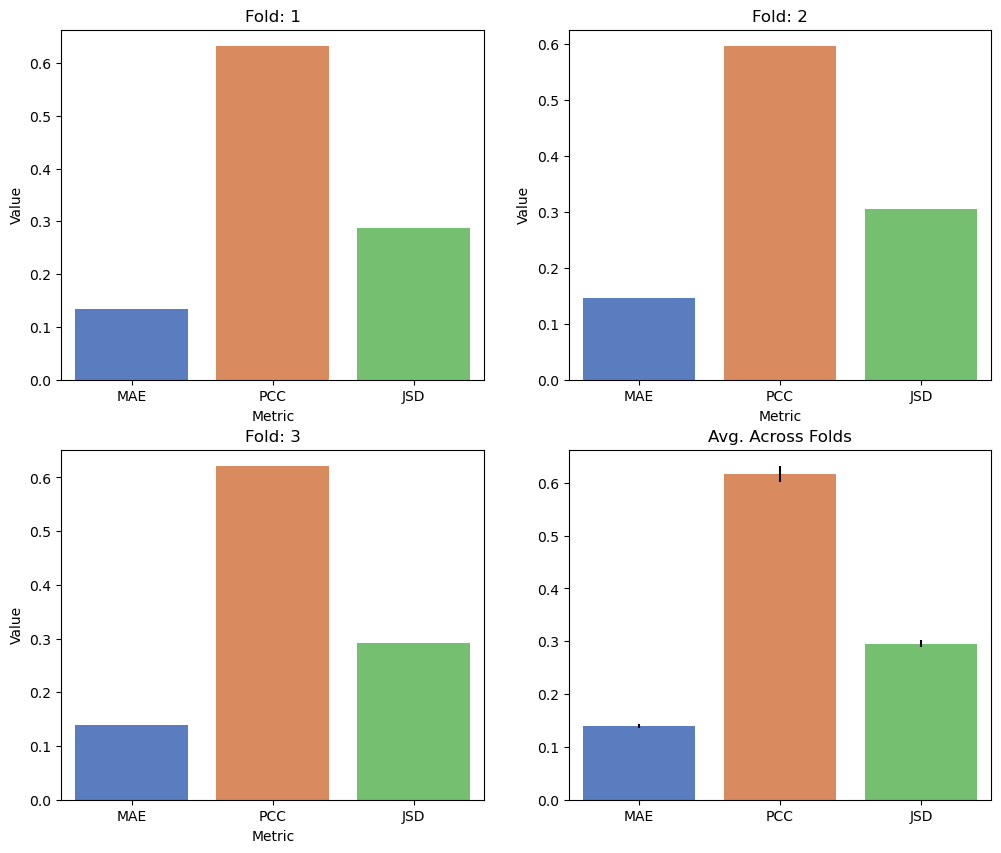

In [14]:
def plot_metrics_fold(res_list):
    df = pd.DataFrame(res_list)
    df = df.rename(columns={"mae": "MAE", "pcc": "PCC", "js_dis": "JSD", "avg_mae_bc": "MAE_(BC)", "avg_mae_ec": "MAE_(EC)", "avg_mae_pc": "MAE_(PC)"})
    df.index = df.index.set_names(['Fold'])
    df.loc['mean'] = df.mean()
    avg_data = df.iloc[-1, :]
    df.loc['std'] = df.std()
    errors = df.iloc[-1, :].tolist()
    df = df.reset_index()
    df = df.iloc[:-2, :]
    df_long = df.melt(id_vars='Fold', var_name='Metric', value_name='Value')
    palette = sns.color_palette("muted", n_colors=len(df_long['Metric'].unique()))
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    for fold in range(3):   
        i = fold // 2
        j = fold % 2
        sns.barplot(x='Metric', y='Value', data=df_long[df_long['Fold'] == fold], ax=axs[i, j], palette=palette)
        axs[i, j].set_title(f"Fold: {fold+1}")

    sns.barplot(x=avg_data.index, y=avg_data.values, ax=axs[1, 1], palette=palette, yerr=errors, capsize=5)
    axs[1, 1].set_title("Avg. Across Folds")
    plt.show()

plot_metrics_fold(res_list)


# Split train and validation

In [15]:
A_HR_train = pd.read_csv("../data/hr_train.csv")

pca = PCA(n_components=0.99, whiten=False)
A_HR_train_pca = pca.fit_transform(A_HR_train)
print(A_HR_train_pca.shape)

gm = GaussianMixture(n_components=5, random_state=random_seed)
A_HR_train_label = gm.fit_predict(A_HR_train_pca)
unique, counts = np.unique(A_HR_train_label, return_counts=True)
print(np.asarray((unique, counts)).T)

X = np.load('A_LR_train_matrix.npy')
y = np.load('A_HR_train_matrix.npy')

n_sample = X.shape[0]
X_train, X_val, y_train, y_val = train_test_split(
    X.reshape(n_sample, -1), 
    y.reshape(n_sample, -1), 
    test_size=0.20, 
    random_state=random_seed,
    stratify=A_HR_train_label
)

X_train = X_train.reshape(-1, LR_size, LR_size)
X_val = X_val.reshape(-1, LR_size, LR_size)
y_train = y_train.reshape(-1, HR_size, HR_size)
y_val = y_val.reshape(-1, HR_size, HR_size)

print("Train size:", len(X_train))
print("Val size:", len(X_val))



(167, 161)
[[ 0 14]
 [ 1 30]
 [ 2 30]
 [ 3 46]
 [ 4 47]]
Train size: 133
Val size: 34


# Train Final Model

In [16]:
netG = GSRNet(ks, args).to(device)
optimizerG = optim.Adam(netG.parameters(), lr=args.lr)

netD = Discriminator(args).to(device)
optimizerD = optim.Adam(netD.parameters(), lr=args.lr)

final_model = train_gan(
    netG, 
    optimizerG, 
    netD,
    optimizerD,
    X_train, 
    y_train, 
    args, 
    test_adj=X_val, 
    test_ground_truth=y_val
)
# final_model = train(netG, optimizerG, X_train, y_train, args, X_val, y_val)

Epoch Progress:   0%|          | 1/200 [00:27<1:31:51, 27.70s/epoch]

Epoch: 1, Train Loss: 1.823136, Train Error: 0.222275, Test Error: 0.187029


Epoch Progress:   1%|          | 2/200 [00:54<1:30:27, 27.41s/epoch]

Epoch: 2, Train Loss: 1.293221, Train Error: 0.183827, Test Error: 0.180152


Epoch Progress:   2%|▏         | 3/200 [01:23<1:31:12, 27.78s/epoch]

Epoch: 3, Train Loss: 1.752706, Train Error: 0.178174, Test Error: 0.176860


Epoch Progress:   2%|▏         | 4/200 [01:50<1:30:35, 27.73s/epoch]

Epoch: 4, Train Loss: 2.686228, Train Error: 0.175000, Test Error: 0.175120


Epoch Progress:   2%|▎         | 5/200 [02:17<1:29:24, 27.51s/epoch]

Epoch: 5, Train Loss: 3.527407, Train Error: 0.172739, Test Error: 0.174703


Epoch Progress:   3%|▎         | 6/200 [02:45<1:28:50, 27.48s/epoch]

Epoch: 6, Train Loss: 4.116730, Train Error: 0.170712, Test Error: 0.172873


Epoch Progress:   4%|▎         | 7/200 [03:13<1:28:43, 27.58s/epoch]

Epoch: 7, Train Loss: 4.479531, Train Error: 0.168756, Test Error: 0.170584


Epoch Progress:   4%|▍         | 8/200 [03:40<1:28:17, 27.59s/epoch]

Epoch: 8, Train Loss: 4.669994, Train Error: 0.166673, Test Error: 0.168268


Epoch Progress:   4%|▍         | 9/200 [04:08<1:27:52, 27.60s/epoch]

Epoch: 9, Train Loss: 4.704902, Train Error: 0.164048, Test Error: 0.166066


Epoch Progress:   5%|▌         | 10/200 [04:35<1:27:06, 27.51s/epoch]

Epoch: 10, Train Loss: 4.663639, Train Error: 0.161444, Test Error: 0.163259


Epoch Progress:   6%|▌         | 11/200 [05:04<1:27:58, 27.93s/epoch]

Epoch: 11, Train Loss: 4.597415, Train Error: 0.158363, Test Error: 0.161174


Epoch Progress:   6%|▌         | 12/200 [05:31<1:27:01, 27.78s/epoch]

Epoch: 12, Train Loss: 4.608354, Train Error: 0.155536, Test Error: 0.158087


Epoch Progress:   6%|▋         | 13/200 [05:59<1:26:14, 27.67s/epoch]

Epoch: 13, Train Loss: 4.761494, Train Error: 0.153265, Test Error: 0.157558


Epoch Progress:   7%|▋         | 14/200 [06:26<1:25:36, 27.62s/epoch]

Epoch: 14, Train Loss: 5.011220, Train Error: 0.150985, Test Error: 0.154060


Epoch Progress:   8%|▊         | 15/200 [06:54<1:25:28, 27.72s/epoch]

Epoch: 15, Train Loss: 5.256332, Train Error: 0.148630, Test Error: 0.152572


Epoch Progress:   8%|▊         | 16/200 [07:22<1:25:24, 27.85s/epoch]

Epoch: 16, Train Loss: 5.537574, Train Error: 0.146840, Test Error: 0.150909


Epoch Progress:   8%|▊         | 17/200 [07:51<1:25:11, 27.93s/epoch]

Epoch: 17, Train Loss: 5.830907, Train Error: 0.145203, Test Error: 0.149838


Epoch Progress:   9%|▉         | 18/200 [08:18<1:24:35, 27.89s/epoch]

Epoch: 18, Train Loss: 6.071883, Train Error: 0.143675, Test Error: 0.148427


Epoch Progress:  10%|▉         | 19/200 [08:48<1:25:59, 28.51s/epoch]

Epoch: 19, Train Loss: 6.291415, Train Error: 0.142649, Test Error: 0.147553


Epoch Progress:  10%|█         | 20/200 [09:16<1:25:02, 28.35s/epoch]

Epoch: 20, Train Loss: 6.571080, Train Error: 0.141556, Test Error: 0.146064


Epoch Progress:  10%|█         | 21/200 [09:44<1:24:19, 28.27s/epoch]

Epoch: 21, Train Loss: 6.857243, Train Error: 0.140062, Test Error: 0.145626


Epoch Progress:  11%|█         | 22/200 [10:13<1:23:57, 28.30s/epoch]

Epoch: 22, Train Loss: 7.121622, Train Error: 0.139078, Test Error: 0.144517


Epoch Progress:  12%|█▏        | 23/200 [10:41<1:23:22, 28.26s/epoch]

Epoch: 23, Train Loss: 7.336020, Train Error: 0.138522, Test Error: 0.143740


Epoch Progress:  12%|█▏        | 24/200 [11:09<1:22:40, 28.18s/epoch]

Epoch: 24, Train Loss: 7.568232, Train Error: 0.137570, Test Error: 0.143021


Epoch Progress:  12%|█▎        | 25/200 [11:37<1:22:27, 28.27s/epoch]

Epoch: 25, Train Loss: 7.832654, Train Error: 0.136674, Test Error: 0.143049


Epoch Progress:  13%|█▎        | 26/200 [12:06<1:22:02, 28.29s/epoch]

Epoch: 26, Train Loss: 8.006768, Train Error: 0.136218, Test Error: 0.142175


Epoch Progress:  14%|█▎        | 27/200 [12:34<1:21:23, 28.23s/epoch]

Epoch: 27, Train Loss: 8.298496, Train Error: 0.136004, Test Error: 0.142794


Epoch Progress:  14%|█▍        | 28/200 [13:02<1:20:32, 28.10s/epoch]

Epoch: 28, Train Loss: 8.541037, Train Error: 0.135386, Test Error: 0.142124


Epoch Progress:  14%|█▍        | 29/200 [13:30<1:20:26, 28.23s/epoch]

Epoch: 29, Train Loss: 8.787656, Train Error: 0.135190, Test Error: 0.141789


Epoch Progress:  15%|█▌        | 30/200 [13:58<1:19:52, 28.19s/epoch]

Epoch: 30, Train Loss: 8.912041, Train Error: 0.134511, Test Error: 0.141634


Epoch Progress:  16%|█▌        | 31/200 [14:26<1:19:10, 28.11s/epoch]

Epoch: 31, Train Loss: 9.150236, Train Error: 0.133659, Test Error: 0.141683


Epoch Progress:  16%|█▌        | 32/200 [14:55<1:19:14, 28.30s/epoch]

Epoch: 32, Train Loss: 9.298752, Train Error: 0.133521, Test Error: 0.141100


Epoch Progress:  16%|█▋        | 33/200 [15:24<1:19:17, 28.49s/epoch]

Epoch: 33, Train Loss: 9.488674, Train Error: 0.133245, Test Error: 0.140927


Epoch Progress:  17%|█▋        | 34/200 [15:52<1:18:45, 28.46s/epoch]

Epoch: 34, Train Loss: 9.638598, Train Error: 0.132775, Test Error: 0.140466


Epoch Progress:  18%|█▊        | 35/200 [16:20<1:18:00, 28.36s/epoch]

Epoch: 35, Train Loss: 9.815591, Train Error: 0.132246, Test Error: 0.140743


Epoch Progress:  18%|█▊        | 36/200 [16:49<1:18:06, 28.57s/epoch]

Epoch: 36, Train Loss: 10.010858, Train Error: 0.131999, Test Error: 0.140387


Epoch Progress:  18%|█▊        | 37/200 [17:18<1:17:43, 28.61s/epoch]

Epoch: 37, Train Loss: 10.141484, Train Error: 0.131666, Test Error: 0.140200


Epoch Progress:  19%|█▉        | 38/200 [17:46<1:17:00, 28.52s/epoch]

Epoch: 38, Train Loss: 10.334852, Train Error: 0.131486, Test Error: 0.140349


Epoch Progress:  20%|█▉        | 39/200 [18:14<1:15:58, 28.31s/epoch]

Epoch: 39, Train Loss: 10.549355, Train Error: 0.131288, Test Error: 0.140592


Epoch Progress:  20%|██        | 40/200 [18:43<1:15:25, 28.28s/epoch]

Epoch: 40, Train Loss: 10.715512, Train Error: 0.131182, Test Error: 0.140313


Epoch Progress:  20%|██        | 41/200 [19:10<1:14:33, 28.13s/epoch]

Epoch: 41, Train Loss: 10.953901, Train Error: 0.130810, Test Error: 0.139587


Epoch Progress:  21%|██        | 42/200 [19:42<1:16:51, 29.19s/epoch]

Epoch: 42, Train Loss: 11.272928, Train Error: 0.130953, Test Error: 0.139829


Epoch Progress:  22%|██▏       | 43/200 [20:15<1:19:08, 30.25s/epoch]

Epoch: 43, Train Loss: 11.427944, Train Error: 0.130676, Test Error: 0.140108


Epoch Progress:  22%|██▏       | 44/200 [20:44<1:17:40, 29.87s/epoch]

Epoch: 44, Train Loss: 11.612103, Train Error: 0.130402, Test Error: 0.139640


Epoch Progress:  22%|██▎       | 45/200 [21:11<1:15:31, 29.23s/epoch]

Epoch: 45, Train Loss: 11.739300, Train Error: 0.129491, Test Error: 0.140035


Epoch Progress:  23%|██▎       | 46/200 [21:40<1:14:47, 29.14s/epoch]

Epoch: 46, Train Loss: 11.929979, Train Error: 0.129028, Test Error: 0.139684


Epoch Progress:  24%|██▎       | 47/200 [22:09<1:13:47, 28.94s/epoch]

Epoch: 47, Train Loss: 12.012464, Train Error: 0.129037, Test Error: 0.139182


Epoch Progress:  24%|██▍       | 48/200 [22:37<1:13:04, 28.84s/epoch]

Epoch: 48, Train Loss: 12.213227, Train Error: 0.128994, Test Error: 0.139421


Epoch Progress:  24%|██▍       | 49/200 [23:06<1:12:09, 28.67s/epoch]

Epoch: 49, Train Loss: 12.349402, Train Error: 0.128753, Test Error: 0.139933


Epoch Progress:  25%|██▌       | 50/200 [23:34<1:11:22, 28.55s/epoch]

Epoch: 50, Train Loss: 12.472907, Train Error: 0.128872, Test Error: 0.140085


Epoch Progress:  26%|██▌       | 51/200 [24:04<1:11:49, 28.93s/epoch]

Epoch: 51, Train Loss: 12.756047, Train Error: 0.128780, Test Error: 0.140475


Epoch Progress:  26%|██▌       | 52/200 [24:32<1:10:54, 28.75s/epoch]

Epoch: 52, Train Loss: 12.833288, Train Error: 0.128200, Test Error: 0.139335


Epoch Progress:  26%|██▋       | 53/200 [25:02<1:11:17, 29.10s/epoch]

Epoch: 53, Train Loss: 13.017590, Train Error: 0.128040, Test Error: 0.139007


Epoch Progress:  27%|██▋       | 54/200 [25:35<1:13:18, 30.13s/epoch]

Epoch: 54, Train Loss: 13.250475, Train Error: 0.127692, Test Error: 0.139755


Epoch Progress:  28%|██▊       | 55/200 [26:11<1:17:32, 32.09s/epoch]

Epoch: 55, Train Loss: 13.390270, Train Error: 0.127601, Test Error: 0.139735


Epoch Progress:  28%|██▊       | 56/200 [26:46<1:19:07, 32.97s/epoch]

Epoch: 56, Train Loss: 13.495238, Train Error: 0.126877, Test Error: 0.139457


Epoch Progress:  28%|██▊       | 57/200 [27:17<1:17:16, 32.42s/epoch]

Epoch: 57, Train Loss: 13.606468, Train Error: 0.126708, Test Error: 0.139260


Epoch Progress:  29%|██▉       | 58/200 [27:54<1:19:54, 33.77s/epoch]

Epoch: 58, Train Loss: 13.782725, Train Error: 0.126522, Test Error: 0.139855


Epoch Progress:  29%|██▉       | 58/200 [28:41<1:10:15, 29.68s/epoch]

Val Error: 0.139007


In [17]:
final_model.eval()
pred_train_matrices = np.zeros(y_train.shape)
pred_val_matrices = np.zeros(y_val.shape)
with torch.no_grad():
    for j, test_adj in enumerate(X_train):
        pred_train_matrices[j], _, _, _ = final_model(torch.from_numpy(test_adj))

    print("Train")
    evaluate(pred_train_matrices, y_train)

    for j, test_adj in enumerate(X_val):
        pred_val_matrices[j], _, _, _ = final_model(torch.from_numpy(test_adj))

    print("Val")
    evaluate(pred_val_matrices, y_val)

Train


100%|██████████| 133/133 [00:01<00:00, 79.80it/s]


MAE:  0.129031207656004
PCC:  0.672110682122565
Jensen-Shannon Distance:  0.27742635889170053
Val


100%|██████████| 34/34 [00:00<00:00, 82.02it/s]


MAE:  0.13900698392287997
PCC:  0.6169298250327053
Jensen-Shannon Distance:  0.28667642614462047


# Predict Test Set

In [18]:
output_pred_list = []
final_model.eval()
with torch.no_grad():
    for i in range(A_LR_test_matrix.shape[0]):
        output_pred, _, _, _ = final_model(torch.Tensor(A_LR_test_matrix[i]))
        output_pred = MatrixVectorizer.vectorize(output_pred).tolist()
        output_pred_list.append(output_pred)

In [19]:
output_pred_stack = np.stack(output_pred_list, axis=0)
output_pred_1d = output_pred_stack.flatten()
assert output_pred_1d.shape == (4007136, )

In [20]:
df = pd.DataFrame({
    "ID": [i+1 for i in range(len(output_pred_1d))],
    "Predicted": output_pred_1d.tolist()
})

df

,ID,Predicted
0,1,0.509134
1,2,0.587657
2,3,0.670832
3,4,0.629114
4,5,0.609724
...,...,...
4007131,4007132,0.015156
4007132,4007133,0.027042
4007133,4007134,0.210012
4007134,4007135,0.359564


In [21]:
df.to_csv("gsr_gan_gat_relu.csv", index=False)